In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d sixhky/open-images-bus-trucks/


100% 366M/367M [00:15<00:00, 29.4MB/s]
100% 367M/367M [00:15<00:00, 25.5MB/s]


In [ ]:
!unzip -qq open-images-bus-trucks.zip

In [ ]:
# Download necessaries
!pip install -q selectivesearch
!pip install -q torch_snippets


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.0/204.0 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 61.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 85.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.9/98.9 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 98.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 30.6/30.6 MB 48.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
#from torchvision.ops import nms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch

from torchvision import transforms, models, datasets
from torch_snippets import *
import selectivesearch

In [ ]:
IMAGE_ROOT = 'images/images'
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:

DF_RAW = pd.read_csv('df.csv')
DF_RAW.head()

,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739
3,00010bf498b64bab,xclick,Bus,1,0.156250,0.371250,0.269188,0.705228,0,0,...,0,0,0.274375,0.371250,0.311875,0.156250,0.269188,0.493882,0.705228,0.521691
4,00013f14dd4e168f,xclick,Bus,1,0.287500,0.999375,0.194184,0.999062,0,1,...,0,0,0.920000,0.999375,0.648750,0.287500,0.194184,0.303940,0.999062,0.523452


In [ ]:
print('Taille de lensemble de données',len(DF_RAW.groupby('ImageID').count()))

Taille de lensemble de données 15225

In [ ]:
print('Nombre détiquettes:')
np.unique(DF_RAW.LabelName.values,return_counts=True)

Nombre détiquettes:

(array(['Bus', 'Truck'], dtype=object), array([11927, 12135]))

In [ ]:
image_id="00006bdb1eb5cd74"
image_path = os.path.join(IMAGE_ROOT,image_id+'.jpg')
image = cv2.imread(image_path, 1)[...,::-1] # conver BGR to RGB
h, w, _ = image.shape


In [ ]:
df = DF_RAW[DF_RAW['ImageID'] == image_id]
boxes = df['XMin,YMin,XMax,YMax'.split(',')].values
boxes = (boxes * np.array([w,h,w,h])).astype(np.uint16).tolist()
classes = df['LabelName'].values.tolist()

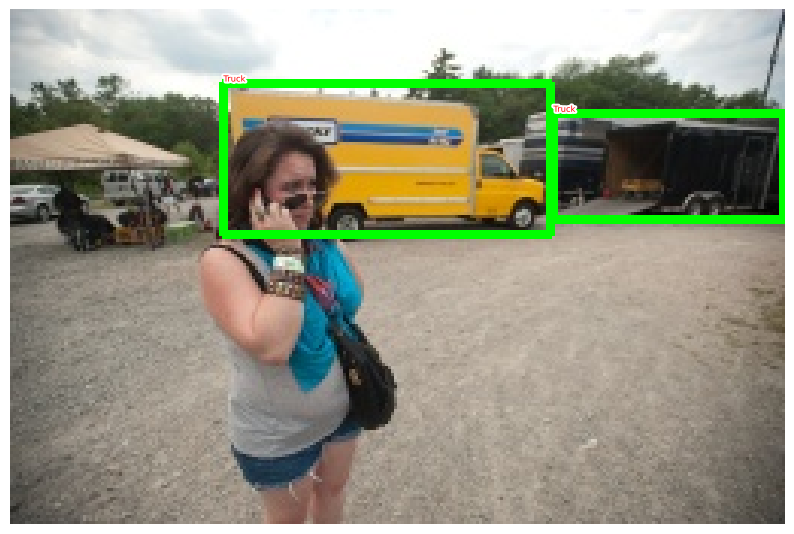

In [ ]:
show(image, bbs=boxes, texts=classes, sz=10)

In [ ]:
def extract_candidates(img):
    img_lbl, regions = selectivesearch.selective_search(img, scale=200, min_size=100)
    img_area = np.prod(img.shape[:2])
    candidates = []
    for r in regions:
        if r['rect'] in candidates: continue
        if r['size'] < (0.05*img_area): continue
        if r['size'] > (1*img_area): continue
        x, y, w, h = r['rect']
        candidates.append(list(r['rect']))
    return candidates

In [ ]:
candidates = extract_candidates(image) # x,y,w,h



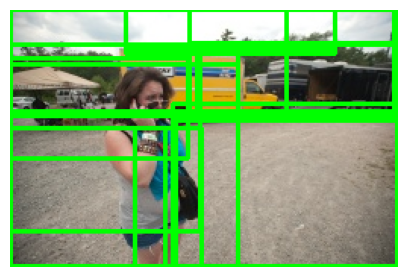

In [ ]:
candidates_viz=[(x,y,x+w,y+h) for x,y,w,h in candidates]
show(image, bbs = candidates_viz)

In [ ]:
print(candidates) #x,y,w,h

[
    [0, 0, 118, 32],
    [76, 0, 138, 25],
    [109, 73, 146, 96],
    [0, 78, 82, 91],
    [107, 73, 148, 96],
    [76, 0, 138, 27],
    [0, 23, 117, 75],
    [0, 78, 102, 91],
    [123, 22, 132, 47],
    [0, 78, 126, 91],
    [0, 36, 150, 133],
    [0, 23, 117, 75],
    [0, 23, 117, 75],
    [0, 23, 117, 75],
    [0, 23, 125, 123],
    [118, 22, 137, 48],
    [0, 0, 182, 67],
    [0, 0, 253, 67],
    [0, 23, 125, 123],
    [0, 23, 125, 123],
    [107, 62, 148, 107],
    [107, 62, 148, 107],
    [0, 23, 150, 146],
    [118, 22, 137, 48],
    [0, 0, 253, 67],
    [0, 23, 255, 146],
    [0, 0, 255, 67],
    [76, 0, 138, 29],
    [0, 0, 255, 70],
    [0, 0, 255, 70],
    [0, 23, 255, 146],
    [0, 23, 255, 146],
    [0, 0, 255, 169]
]

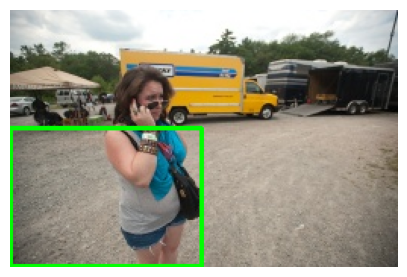

In [ ]:
show(image, bbs = candidates_viz[9:10])

In [ ]:
candidates[9] #x,y,w,h

[0, 78, 126, 91]

In [ ]:
y,y+h,x,x+w

(78, 169, 0, 126)

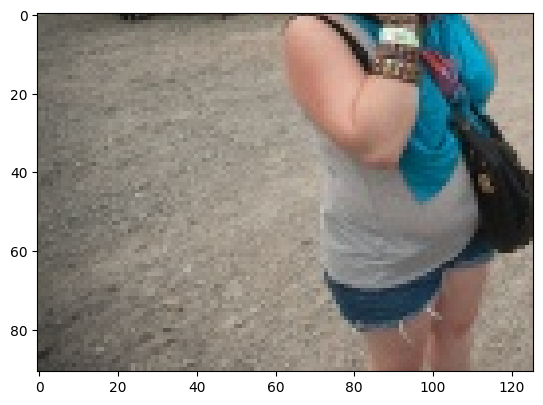

In [ ]:
x,y,w,h= candidates[9]
crop=image[y:y+h,x:x+w]
plt.imshow(crop)

In [ ]:

crop=cv2.resize(crop, (224,224))


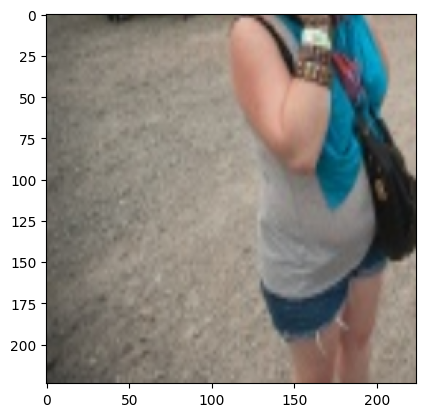

In [ ]:
plt.imshow(crop)

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
def preprocess_image(img):
    img = torch.tensor(img).permute(2,0,1)
    img = normalize(img)
    return img.to(device).float()
def decode(_y):
    _, preds = _y.max(-1)
    return preds


In [ ]:
crop=preprocess_image(crop/255.)[None]
print(crop.shape)

torch.Size([1, 3, 224, 224])

In [ ]:
vgg_backbone = models.vgg16(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
vgg_backbone(crop).shape

torch.Size([1, 1000])

In [ ]:

vgg_backbone.classifier = nn.Sequential()
for param in vgg_backbone.parameters():
    param.requires_grad = False
vgg_backbone.eval().to(device)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
def extract_iou(boxA, boxB, epsilon=1e-5):
    x1 = max(boxA[0], boxB[0])
    y1 = max(boxA[1], boxB[1])
    x2 = min(boxA[2], boxB[2])
    y2 = min(boxA[3], boxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height <0):
        return 0.0
    area_overlap = width * height
    area_a = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    area_b = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    area_combined = area_a + area_b - area_overlap
    iou = area_overlap / (area_combined+epsilon)
    return iou

In [ ]:
H, W, _ = image.shape

In [ ]:
candidates = np.array([(x,y,x+w,y+h) for x,y,w,h in candidates]) # xmin,ymin,xmax,ymax
ious, rois, clss, deltas = [], [], [], []
ious = np.array([[extract_iou(candidate, _bb_) for candidate in candidates] for _bb_ in boxes ]).T
for jx, candidate in enumerate(candidates):
        cx,cy,cX,cY = candidate
        candidate_ious = ious[jx] # GT IOU

        best_iou_at = np.argmax(candidate_ious) # maxium IOU  GT
        best_iou = candidate_ious[best_iou_at]
        best_bb = _x,_y,_X,_Y = boxes[best_iou_at]

        if best_iou > 0.3: clss.append(classes[best_iou_at])
        else : clss.append('background')

        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate / np.array([W,H,W,H]))

In [ ]:
ious.T.shape

(2, 33)

In [ ]:
np.argmax(ious.T,1).shape

(2,)

In [ ]:
np.argmax(candidate_ious.T)

32

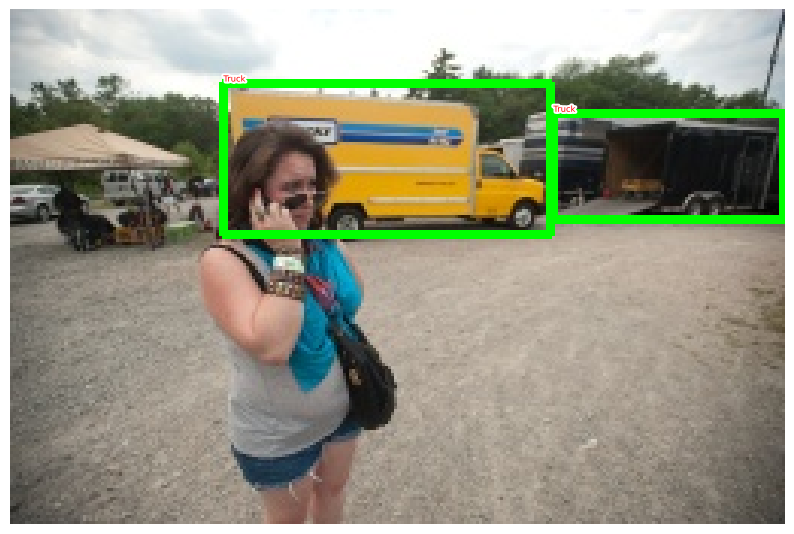

In [ ]:
show(image, bbs=boxes, texts=classes, sz=10)

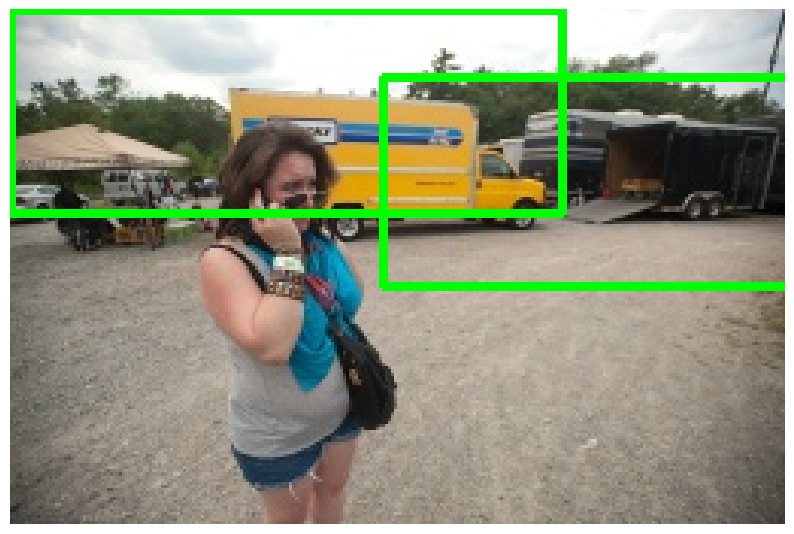

In [ ]:
show(image, bbs=candidates[np.argmax(ious.T,1)], sz=10)

In [ ]:
np.max(ious.T,1)

array([0.35861004, 0.15117931])